# Variational MC solution of the Schroedinger Equation

We adjust the variational MC to look at the hydrogen and helium atoms. 

### Compile and import

In [1]:
! swig -c++ -python swig/vmc.i
! python swig/setup_vmc.py build_ext --inplace

running build_ext
building '_vmc' extension
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.7m -c swig/vmc_wrap.cxx -o build/temp.linux-x86_64-3.7/swig/vmc_wrap.o -I./ -std=c++11 -O3
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.7m -c vmc.cpp -o build/temp.linux-x86_64-3.7/vmc.o -I./ -std=c++11 -O3
vmc.cpp: In member function ‘virtual double Helium::p(const State&, const State&)’:
vmc.cpp:236:10: warning: unused variable ‘den’ [-Wunused-variable]
  236 |   double den = (1 + alpha * r12.p());
      |      

In [2]:
import sys
import os
sys.path.append( os.path.abspath("swig") )

In [3]:
import vmc
import numpy as np
import matplotlib.pyplot as plt

### QHO

For the QHO we can use Gaussian trial functions:

$$
\psi(x) = A\exp(-\alpha x^2)
$$

The QHO Hamiltonian is

$$
H = -\frac{1}{2}\frac{d^2}{dx^2} + \frac{1}{2}x^2
$$

and so we see our local energies are

$$
E_L =\frac{H\psi}{\psi} = \alpha + x^2 \left(\frac{1}{2} - 2 \alpha^2\right)
$$

and the Metropolis probability function is 

$$
P = \frac{|\psi(x_T)|^2}{|\psi(x)|^2} = \exp\left(-2\alpha\left(x_T^2 - x^2\right)\right)
$$


#### First get the optimal value of $\alpha$

In [4]:
N=10 
alphas=np.arange(0.1,1.5,0.1, dtype=np.float64)
MCSteps=10000
evals = []
for alpha in alphas:
    qho = vmc.QHO(N,[alpha],MCSteps)
    qho.adjustStep()
    qho.doProductionSteps()
    qho.normPsi()
    e = qho.get_eAve()
    evals.append(e)
alpha_opt = alphas[np.argmin(evals)]

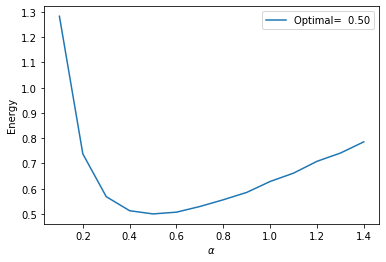

In [5]:
plt.plot(alphas,evals, label="Optimal=%6.2f" % alpha_opt)
plt.legend()
plt.xlabel(r'$\alpha$')
plt.ylabel('Energy')
plt.show()

#### Now plot the wavefunction for the optimal value

In [6]:
qho = vmc.QHO(N,[alpha_opt],MCSteps)
qho.adjustStep()
qho.doProductionSteps()
qho.normPsi()
xMin = qho.get_xMin()
xMax = qho.get_xMax()
dx = qho.get_dx()
xvals = np.arange(xMin, xMax, dx)
psi = np.sqrt( np.abs(qho.get_psiSqd()) )
e = qho.get_eAve()
truth = 1/np.pi**0.25 * np.exp(-xvals**2 / 2)

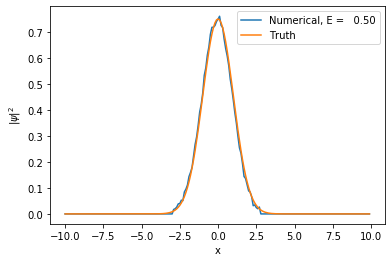

In [7]:
plt.plot(xvals, psi, label="Numerical, E = %6.2f" % (e))
plt.plot(xvals, truth, label="Truth")
plt.xlabel("x")
plt.ylabel(r"$|\psi|^2$")
plt.legend()
plt.show()

### Hydrogen atom

For the Hydrogen atom, we need to convert to three dimensions, and then utilize the radial part only. Alternatively you can appropriately treat this as a 1d problem with the correct interpretation of the variables. We can use Slater trial functions:

$$
\psi(x) = A\exp(-\alpha x)
$$

The Hydrogen atom Hamiltonian in dimensionless units for the spherically symmetric states is

$$
H = -\frac{1}{2}\frac{1}{r^2}\frac{d}{dr}\left(r^2 \frac{d}{dr}\right) - \frac{1}{r}
$$

and so we see our local energies are

$$
E_L =\frac{H\psi}{\psi} = -\frac{1}{r}\left(1 - \alpha\right) - \frac{\alpha^2}{2}
$$

and the Metropolis probability function is 

$$
P = \frac{|\psi(r_T)|^2}{|\psi(r)|^2} = \exp\left(-2\alpha\left(r_T - r\right)\right)
$$

#### First get the optimal value of $\alpha$

In [9]:
N=100
alphas=np.arange(0., 2, 0.1, dtype=np.float64)
MCSteps=1000
evals = []
for alpha in alphas:
    h = vmc.Hydrogen(N,[alpha],MCSteps)
    h.adjustStep()
    h.doProductionSteps()
    h.normPsi()
    e = h.get_eAve()
    evals.append(e)
alpha_opt = alphas[np.argmin(evals)]

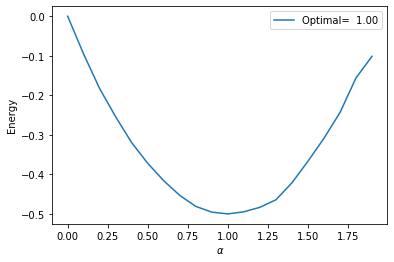

In [10]:
plt.plot(alphas,evals, label="Optimal=%6.2f" % alpha_opt)
plt.legend()
plt.xlabel(r'$\alpha$')
plt.ylabel('Energy')
plt.show()

#### Now plot the wavefunction for the optimal value

In [11]:
N=1000
MCSteps=10000
h = vmc.Hydrogen(N,[alpha_opt],MCSteps)
h.adjustStep()
h.doProductionSteps()
h.normPsi()
xMin = h.get_xMin()
xMax = h.get_xMax()
dx = h.get_dx()
xvals = np.arange(xMin, xMax, dx)
psi = np.sqrt( np.abs(h.get_psiSqd()) )
e = h.get_eAve()


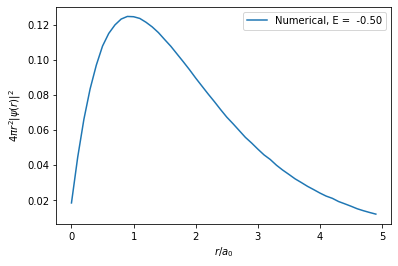

In [12]:
plt.plot(xvals, psi, label="Numerical, E = %6.2f" % (e))
plt.xlabel(r"$r/a_0$")
plt.ylabel(r"$4\pi r^2|\psi(r)|^2$")
plt.legend()
plt.show()

### Helium atom


For Helium-like atom, we are required to convert to three dimensions, and we have two separate positions to keep track of. We will assume trial functions like

$$
\psi(\vec{r}_1, \vec{r}_2) = \exp(-Z r_1)\;\cdot\;\exp(-Z r_2)\;\cdot\;\exp(-\beta r_{12} / (1 + \alpha r_{12}))
$$

You're welcome to vary with respect to $Z$ and $\beta$, but I only expect you to adjust $\alpha$, and you can set $Z=2$ and $\beta=1/2$, which is the case for Helium itself. 

The Helium atom Hamiltonian in dimensionless units is

$$
H = -\frac{1}{2}\nabla_1^2 -\frac{1}{2}\nabla_2^2 - \frac{2}{r_1} - \frac{2}{r_2} + \frac{2}{r_{12}}
$$

You're only required to look at the spherically symmetric states, so you can substitute the appropriate derivative as above for the hydrogen atom. 

We see our local energies are

$$
\begin{array}{c}E_{L}\left(\vec{r}_{1}, \vec{r}_{2}\right)=-4+\frac{\alpha}{\left(1+\alpha r_{12}\right)}+\frac{\alpha}{\left(1+\alpha r_{12}\right)^{2}}+\frac{\alpha}{\left(1+\alpha r_{12}\right)^{3}} \\ -\frac{1}{4\left(1+\alpha r_{12}\right)^{4}}+\frac{\hat{r}_{12} \cdot\left(\hat{r}_{1}-\hat{r}_{2}\right)}{\left(1+\alpha r_{12}\right)^{2}}\end{array}
$$


and the Metropolis probability function is 

$$
P = \frac{|\psi(r_{1T},r_{2T})|^2}{|\psi(r_1,r_2)|^2}
$$

where $\psi(\vec{r}_1, \vec{r}_2)$ is as given above. 

#### First get the optimal value of $\alpha$

In [14]:
N=1000
alphas=np.arange(0.0,0.5,0.05, dtype=np.float64)
MCSteps=10000
evals = []
for alpha in alphas:
    he = vmc.Helium(N,[alpha],MCSteps)
    he.adjustStep()
    he.doProductionSteps()
    he.normPsi()
    e = he.get_eAve()
    evals.append(e)
alpha_opt = alphas[np.argmin(evals)]

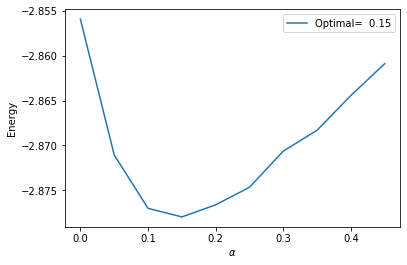

In [15]:
plt.plot(alphas,evals, label="Optimal=%6.2f" % alpha_opt)
plt.xlabel(r'$\alpha$')
plt.ylabel('Energy')
plt.legend()
plt.show()

#### Now plot the wavefunction for the optimal value

In [16]:
he = vmc.Helium(N,[alpha_opt],MCSteps)
he.adjustStep()
he.doProductionSteps()
he.normPsi()
xMin = he.get_xMin()
xMax = he.get_xMax()
dx = he.get_dx()
xvals = np.arange(xMin, xMax, dx)
psi = np.sqrt( np.abs(he.get_psiSqd()) )
e = he.get_eAve()
truth = 1/np.pi**0.5 * np.exp(-xvals)

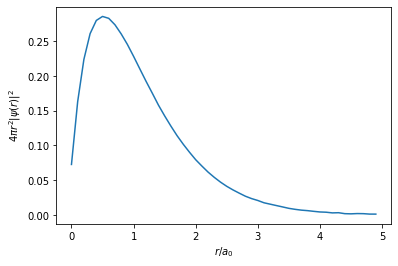

In [17]:
plt.plot(xvals, psi)
plt.xlabel(r"$r/a_0$")
plt.ylabel(r"$4\pi r^2|\psi(r)|^2$")
plt.show()